## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Some imports up here

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import time

%matplotlib qt

## First here's some calibration code (mostly from the sample code)

In [2]:

def get_calibration(img_list):
    """
    Returns some calibrated points based on a list of images
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    for fname in img_list:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    return (objpoints, imgpoints)

# Make a list of calibration images
calibration_images = glob.glob('camera_cal/calibration*.jpg')

# global calibration values
objpoints, imgpoints = get_calibration(calibration_images)
target_dimensions = (720, 1280)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, target_dimensions, None, None)

# nx, ny values to use for undistorting
max_points = np.max(objpoints[0], axis=0) + 1
nx = int(max_points[0])
ny = int(max_points[1])


## Some helper methods we will be using for debugging output

In [3]:
def plot_image(img):
    """
    Creates a plot and displays an image on it
    """
    figure = plt.figure(figsize = (18,10))
    axes = figure.add_subplot(111)

    is_grayscale = len(img) != 3
    if is_grayscale is True:
        axes.imshow(img, cmap='gray', aspect='auto', interpolation='nearest') 
    else:
        axes.imshow(img, aspect='auto', interpolation='nearest') 

def make_3_channel_image_from_binary_channel(bin_channel):
    """
    Takes a single-channel binary image (1s and 0s) and triples the channels
    """
    return np.dstack((bin_channel, bin_channel, bin_channel)) * 255


## Method for compositing the final image

In [4]:
def weighted_img(bottom_image, top_image, bottom_image_opacity=1, top_image_opacity=0.6, γ=0.):
    """
    Overlays a couple images on each other
    """
    return cv2.addWeighted(bottom_image, bottom_image_opacity, top_image, top_image_opacity, γ)

## A few methods for finding lane line pixels either from a prior lane line representation or a sliding window rectangle

In [5]:

def get_pixels_in_window(nonzero, bounds):
    """
    Given a rectangular window and a binary image, find all the non-zero pixels inside the window
    """
    nonzeroy, nonzerox = nonzero
    min_x, max_x, min_y, max_y = bounds
    return ((nonzeroy >= min_y) & (nonzeroy < max_y) & (nonzerox >= min_x) &  (nonzerox < max_x)).nonzero()[0]

def get_x_from_poly(fit_fn, y):
    """
    Given a polynomial function (quadratic in this case) and a y value, get the x value
    (We draw the parabola "sideways" in the image to represent the lane line)
    """

    a, b, c = fit_fn
    return a * y ** 2 + b * y + c

def get_pixels_from_prior(nonzero, prior_fit_fn, margin, height):
    """
    Given a binary window, a prior polynomial function, and a max y,
    find all pixels within a certain horizontal margin
    """
    result = []
    nonzeroy, nonzerox = nonzero
    for i in range(height):
        x = get_x_from_poly(prior_fit_fn, i)
        min_x = x - margin
        max_x = x + margin
        ((i == nonzeroy) & (nonzerox >= min_x) & (nonzerox < max_x)).nonzero()
        result.extend(((i == nonzeroy) & (nonzerox >= min_x) & (nonzerox < max_x)).nonzero()[0])
    return result

## A few methods for finding and drawing lane lines on an image

In [6]:
def draw_lane_on_image(new_image, left_line, right_line):
    """
    This method draws 3 things: left lane line, right lane line, and a polygon representation of the lane
    """
    left_x, left_y = left_line.get_x_and_y()
    right_x, right_y = right_line.get_x_and_y()

    pts_left = np.array([np.transpose(np.vstack([left_x, left_y]))]) if len(left_x) > 0 and len(left_y) > 0 else []
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_x, right_y])))]) if len(right_x) > 0 and len(right_y) > 0 else []

    if len(left_x) > 0 and len(right_x) > 0:
        pts = np.hstack((pts_left, pts_right))
        cv2.fillPoly(new_image, np.int_([pts]), (255, 255, 0))

    cv2.polylines(new_image, np.int32([pts_left]), 0, [0,255,0], 15)
    cv2.polylines(new_image, np.int32([pts_right]), 0, [0,255,0], 15)

def get_image_of_found_lane(binary_warped, max_y, visualize=False):
    """
    Finds lane lines in an existing binary image and returns a new image with lane lines overlaid on top
    """
    find_and_update_lane_lines(binary_warped, left_line, right_line, visualize)

    warped_three_channel = make_3_channel_image_from_binary_channel(binary_warped)    
    new_image = np.zeros_like(warped_three_channel)

    draw_lane_on_image(new_image, left_line, right_line)
    return new_image

def find_and_update_lane_lines(binary_warped, left_line, right_line, visualize=False):
    """
    Finds lane lines in a binary image and updates their representations
    """
    if left_line.detected == True and right_line.detected == True:
        # If left and right lanes were detected previously, then use those previous detections
        # to find the updated lane lines
        leftx, lefty, rightx, righty = find_lane_from_prior(
            binary_warped,
            left_line.average_fit,
            right_line.average_fit,
            visualize
        )
    else:
        # If either of the lane lines wasn't detected previously, then perform a new sliding window search
        leftx, lefty, rightx, righty = find_lane_sliding_windows(binary_warped, visualize)

    left_line.update_line(lefty, leftx)
    right_line.update_line(righty, rightx)


## Methods for finding lane lines via sliding windows or within a margin of the previous detection

In [7]:
def find_lane_from_prior(binary_warped, left_fit, right_fit, visualize=False):
    margin = 50

    # get the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy, nonzerox = nonzero
    
    left_lane_inds = get_pixels_from_prior(nonzero, left_fit, margin, binary_warped.shape[0])
    right_lane_inds = get_pixels_from_prior(nonzero, right_fit, margin, binary_warped.shape[0])
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def find_lane_sliding_windows(binary_warped, visualize=False):
    img_height = binary_warped.shape[0]

#     num_windows = 7
    num_windows = 6
    margin = 150
    minpix = 100

    # get the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy, nonzerox = nonzero

    histogram = np.sum(binary_warped[img_height // 2:,:], axis=0)
    out_img = make_3_channel_image_from_binary_channel(binary_warped)

    # find midpoint of histogram
    midpoint = np.int(histogram.shape[0] // 2)
    # take midpoint of left and right sides as the start location for the search
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    window_height = np.int(img_height // num_windows)

    # some initial values for the search
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(num_windows):
        win_y_low = img_height - (window + 1) * window_height
        win_y_high = img_height - window * window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        if visualize is True:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(255,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(255,255,0), 2) 
        
        good_left_inds = get_pixels_in_window(nonzero, (win_xleft_low, win_xleft_high, win_y_low, win_y_high))
        good_right_inds = get_pixels_in_window(nonzero, (win_xright_low, win_xright_high, win_y_low, win_y_high))

        if len(good_left_inds) > 0:
            left_lane_inds.append(good_left_inds)
        if len(good_right_inds) > 0:
            right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    if len(left_lane_inds) > 0:
        left_lane_inds = np.concatenate(left_lane_inds)
    if len(right_lane_inds) > 0:
        right_lane_inds = np.concatenate(right_lane_inds)
    if visualize is True:
        plot_image(out_img)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


In [8]:
def sobel(img, sobel_kernel, mag_thresh=(0, 255), dir_thresh=(0, np.pi/2)):
    mag_thresh_min, mag_thresh_max = mag_thresh
    dir_thresh_min, dir_thresh_max = dir_thresh
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)

    # magnitude sobel
    abs_sobel_xy = np.sqrt(abs_sobel_x ** 2 + abs_sobel_y ** 2)
    scaled_sobel = np.uint8(255 * abs_sobel_xy / np.max(abs_sobel_xy))

    # directional sobel
    sobel_dir = np.arctan2(abs_sobel_y, abs_sobel_x)

    output_mag = np.zeros_like(scaled_sobel)
    output_mag[
        (scaled_sobel >= mag_thresh_min) &
        (scaled_sobel <= mag_thresh_max)
    ] = 1

    output_dir = np.zeros_like(scaled_sobel)
    output_dir[
        (sobel_dir >= dir_thresh_min) &
        (sobel_dir <= dir_thresh_max)
    ] = 1

    return output_mag, output_dir

## Process the image

In [9]:
def find_edges(img, debug=False):
    """
    Find edges in an image using these main techniques:
    1) Extract white/yellow pixels
    2) Extract directional / magnitude gradients via the Sobel operator
    3) Bitwise AND for Sobel gradients (direction/magnitude)
    4) Bitwise OR of white/yellow pixel masks together with the Sobel gradients
       to fill in whatever pixels Sobel missed
    """
    img = np.copy(img)


    yellow_h_thresh = (12, 33)
    yellow_s_thresh = (50, 255)
    yellow_v_thresh = (75, 255)
    white_h_thresh = (0, 179)
    white_s_thresh = (0, 25)
    white_v_thresh = (190, 255)

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]

    # threshold color channels to capture yellow
    h_binary = np.zeros_like(h)
    s_binary = np.zeros_like(s)
    v_binary = np.zeros_like(v)
    h_binary[(h >= yellow_h_thresh[0]) & (h <= yellow_h_thresh[1])] = 1
    s_binary[(s >= yellow_s_thresh[0]) & (s <= yellow_s_thresh[1])] = 1
    v_binary[(v >= yellow_v_thresh[0]) & (v <= yellow_v_thresh[1])] = 1
    yellow_binary = h_binary & s_binary & v_binary
    
    # threshold color channels to capture white
    h_binary = np.zeros_like(h)
    s_binary = np.zeros_like(s)
    v_binary = np.zeros_like(v)
    h_binary[(h >= white_h_thresh[0]) & (h <= white_h_thresh[1])] = 1
    s_binary[(s >= white_s_thresh[0]) & (s <= white_s_thresh[1])] = 1
    v_binary[(v >= white_v_thresh[0]) & (v <= white_v_thresh[1])] = 1
    white_binary = h_binary & s_binary & v_binary

    
    dir_thresh = (0.7, 1.2)
    mag_thresh = (70, 130)
    sobel_mag, sobel_dir = sobel(img, sobel_kernel=9, mag_thresh=mag_thresh, dir_thresh=dir_thresh)

    result = white_binary | yellow_binary | (sobel_mag & sobel_dir)

    if debug is True:
        plot_image(yellow_binary)
        plot_image(white_binary)
        plot_image(sobel_mag)
        plot_image(sobel_dir)
        plot_image(result)

    return result
    

## Define a Line class that keeps track of our line detections

In [10]:
class Line():
    # class var to tune averaging
    num_frames_to_average = 4

    def __init__(self, max_x, max_y, ym_per_pix, xm_per_pix):
        self.max_x = max_x
        self.max_y = max_y
        self.best_y = np.linspace(0, self.max_y - 1, self.max_y)
        self.best_x = []
        self.ym_per_pix = ym_per_pix
        self.xm_per_pix = xm_per_pix

        # was the line detected in the last iteration?
        self.detected = False

        # x values of the last n fits of the line
        self.recent_xfitted = [] 

        #average x values of the fitted line over the last n iterations
        self.all_fits = []  
        self.all_fits_world = []
        self.average_fit = []
        self.average_fit_world = []

        # radius of curvature of the line in some units
        self.average_curvature = None 
        self.all_curvature_values = []

        # distance in meters of vehicle center from the line
        self.offset_world = 0

    def get_curvature(self, average_fit, y, ym_per_pix):
        a, b, c = average_fit
        return ((1 + (2 * a * y * ym_per_pix + b) ** 2) ** 1.5) / abs(2 * a)
        
    def update_line(self, laney, lanex):
        
        coefficients = np.polyfit(laney, lanex, 2) if len(lanex) > 0 and len(laney) > 0 else []
        coefficients_world = np.polyfit(laney * self.ym_per_pix, lanex * self.xm_per_pix, 2) if len(lanex) > 0 and len(laney) > 0 else []
       
        if len(self.average_fit) == 0:
            self.average_fit = coefficients
            self.average_fit_world = coefficients_world

        if len(coefficients) > 0:
            self.detected = True
            self.all_fits.append(coefficients)
            self.all_fits_world.append(coefficients_world)
            self.all_curvature_values.append(self.get_curvature(self.average_fit_world, self.max_y - 1, self.ym_per_pix))
        else:
            self.detected = False

        if len(self.all_fits) > self.num_frames_to_average:
            self.all_fits.pop(0)
            self.all_fits_world.pop(0)
            self.all_curvature_values.pop(0)

        self.average_fit = np.sum(self.all_fits, axis=0) / len(self.all_fits)
        self.average_fit_world = np.sum(self.all_fits_world, axis=0) / len(self.all_fits_world) if len(self.all_fits_world) else 0
        self.average_curvature = sum(self.all_curvature_values) / len(self.all_curvature_values) if len(self.all_curvature_values) else 0

        if hasattr(self.average_fit, "__len__"):
            self.best_x = get_x_from_poly(self.average_fit, self.best_y)

    def get_x_and_y(self):
        return self.best_x, self.best_y


In [11]:
def reset_detections():
    """
    Resets previously instantiated left and right Line instances
    """
    global left_line
    global right_line

    left_line = Line(img_width, img_height, ym_per_pix, xm_per_pix)
    right_line = Line(img_width, img_height, ym_per_pix, xm_per_pix)

def calibrate_for_main_video():
    """
    Sets up transformation matrices for the main video
    """
    global src
    global dst
    global M
    global M_inv
    reset_detections()

    # top of the trapezoid
    img_transform_min_y = 450
    # offset from the center of the image
    img_transform_top_center_offset = 49
    # offset from the side of the image
    img_transform_bottom_side_offset = 150

    src = np.float32([
        [img_transform_bottom_side_offset, img_height],
        [img_width / 2 - img_transform_top_center_offset, img_transform_min_y],
        [img_width / 2 + img_transform_top_center_offset, img_transform_min_y],
        [img_width - img_transform_bottom_side_offset, img_height]
    ])
    dst = np.float32([
        [300, img_height],
        [300, 0],
        [img_width - 300, 0],
        [img_width - 300, img_height]
    ])

    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
def calibrate_for_challenge():
    """
    Sets up transformation matrices for the challenge video
    """
    global src
    global dst
    global M
    global M_inv

    reset_detections()
    # top of the trapezoid
    # the perspective of this video seems to be higher up so we want to adjust the transform accordingly
    img_transform_min_y = 470
    # offset from the center of the image
    img_transform_top_center_offset = 45
    # offset from the side of the image
    img_transform_bottom_side_offset = 230

    src = np.float32([
        [img_transform_bottom_side_offset, img_height],
        [img_width / 2 - img_transform_top_center_offset, img_transform_min_y],
        [img_width / 2 + img_transform_top_center_offset, img_transform_min_y],
        [img_width - img_transform_bottom_side_offset, img_height]
    ])
    dst = np.float32([
        [300, img_height],
        [300, 0],
        [img_width - 300, 0],
        [img_width - 300, img_height]
    ])

    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    

In [16]:
img_height, img_width = target_dimensions
lane_width = 3.66
# placeholder values
# meters per pixel in y dimension
# estimated by using average length of and distance between white lane dashes (total of ~125 feet covered)
ym_per_pix = 38.1 / 720

# meters per pixel in the x direction;
# estimated from average lane width (~12 feet) and the number of pixels
# between the lane lines at the bottom of the screen (assume y=720 is directly below the camera)
xm_per_pix = lane_width / 620

# top of the trapezoid
img_transform_min_y = 450
# offset from the center of the image
img_transform_top_center_offset = 49
# offset from the side of the image
img_transform_bottom_side_offset = 150

src = np.float32([
    [img_transform_bottom_side_offset, img_height],
    [img_width / 2 - img_transform_top_center_offset, img_transform_min_y],
    [img_width / 2 + img_transform_top_center_offset, img_transform_min_y],
    [img_width - img_transform_bottom_side_offset, img_height]
])
dst = np.float32([
    [300, img_height],
    [300, 0],
    [img_width - 300, 0],
    [img_width - 300, img_height]
])

M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)

# a somewhat straight line is something with a radius curvature radius of greater than 10km
somewhat_straight_curvature_radius = 5000
min_non_centered_offset = 0.01

# instantiate variables
left_line = Line(img_width, img_height, ym_per_pix, xm_per_pix)
right_line = Line(img_width, img_height, ym_per_pix, xm_per_pix)

def format_in_meters(some_num):
    """
    Takes a number of meters and rounds to 4 digits after the decimal.
    If the number is less than 1 meter, then output as centimeters with 2 digits after the decimal.
    """
    rounded = round(some_num, 4)
    if rounded < 1:
        rounded *= 100
        unit = 'cm'
    else:
        unit = 'm'
    return str(rounded) + unit

def get_world_offset(left_line, right_line):
    """
    Given 2 Line instances (left line, right line), output the camera car's offset relative to them.
    This assumes the camera is perfectly centered on the camera car.
    """
    best_x_left, best_y_left = left_line.get_x_and_y()
    best_x_right, best_y_right = right_line.get_x_and_y()
    if len(best_x_left) is 0 or len(best_x_right) is 0:
        return 'unknown'
    width_of_lane_on_screen = best_x_right[-1] - best_x_left[-1]
    distance_from_center = best_x_right[-1] - width_of_lane_on_screen / 2 - img_width / 2
    return distance_from_center * xm_per_pix
    
def get_lane_curvature(left_line, right_line):
    """
    Given 2 Line instances (left line, right line), output their average curvature
    """
    return (left_line.average_curvature + right_line.average_curvature) / 2
    
def annotate_image(img, left_line, right_line):
    """
    Given an image and 2 Line instances, this composites lane curvature and offset metrics onto the image
    """
    curvature = get_lane_curvature(left_line, right_line)
    offset = get_world_offset(left_line, right_line)
        
    # if the radius of the curve is below a certain threshold, then we'll call it moving straight
    if curvature < somewhat_straight_curvature_radius:
        curvature_string = format_in_meters(curvature)
    else:
        curvature_string = 'straight line-ish'

    # offset logic    
    if offset is 'unknown':
        offset_string = offset
    elif abs(offset) < min_non_centered_offset:
        # if the offset is less than 1cm, we'll say the car is centered
        offset_string = 'centered-ish'        
    elif offset < 0:
        offset_string = format_in_meters(abs(offset)) + ' right'
    else:
        offset_string = format_in_meters(abs(offset)) + ' left'

    cv2.putText(img, 'curvature: ' + curvature_string, (25, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(img, 'offset: ' + offset_string, (25, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    
def process_video(input_filename, output_filename, subclip_range=None):
    """
    Generic method to process an input video and output it to output_filename
    The caller can optionally specify a subclip range (e.g. for debug purposes)
    """
    clip = VideoFileClip(input_filename)
    if subclip_range is not None:
        start_time, end_time = subclip_range
        clip = clip.subclip(start_time, end_time)
    clip_output = clip.fl_image(process_image)
    %time clip_output.write_videofile(output_filename, audio=False)

def process_image(img, debug=False):
    """
    Complete method for taking an image of the road, transforming and finding lane lines on it,
    and outputting a final image with the lane lines and curvature/offset metrics.
    """
    img_height, img_width, num_channels = img.shape

    # step 1: undistort using previously determined values
    undistorted = cv2.undistort(img, mtx, dist, None)

    if debug is True:
        plot_image(undistorted)

    # step 2: find some edges in the untransformed image
    edges = find_edges(undistorted, debug)

    # step 3: transform edges image using a pre-computed transform
    warped = cv2.warpPerspective(edges, M, (img_width, img_height), flags=cv2.INTER_LINEAR)
    
    plot_image(undistorted)
    plot_image(cv2.warpPerspective(undistorted, M, (img_width, img_height), flags=cv2.INTER_LINEAR))
    # step 4: create an image of the detected lane
    image_of_lane = get_image_of_found_lane(warped, img_height, debug)

    # step 5: unwarp image of the lane
    unwarped_lane = cv2.warpPerspective(image_of_lane, M_inv, (img_width, img_height), flags=cv2.INTER_LINEAR)
    
    # step 6: composite the unwarped lane image back onto the original image
    weighted_final = weighted_img(undistorted, unwarped_lane, 1, 0.5)
    
    # step 7: compute and add annotations for curvature and offset to the final image
    annotate_image(weighted_final, left_line, right_line)
    
    if debug is True:
        plot_image(weighted_final)

    return weighted_final


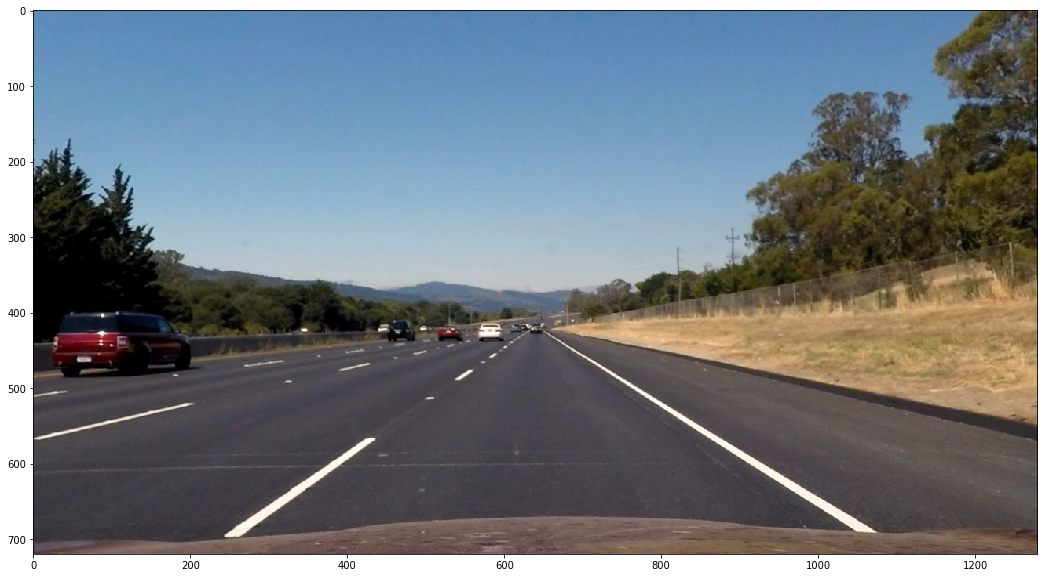

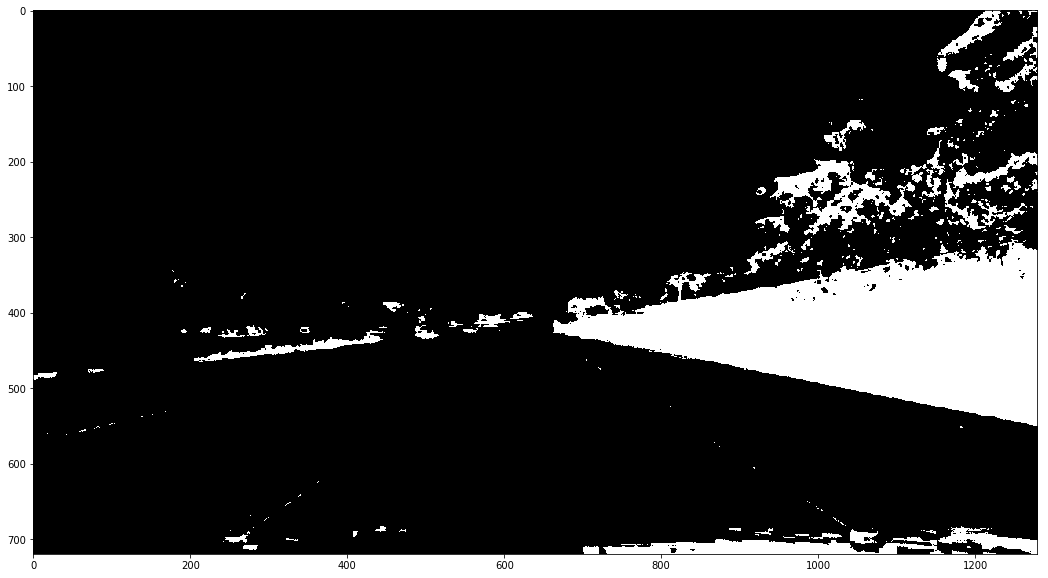

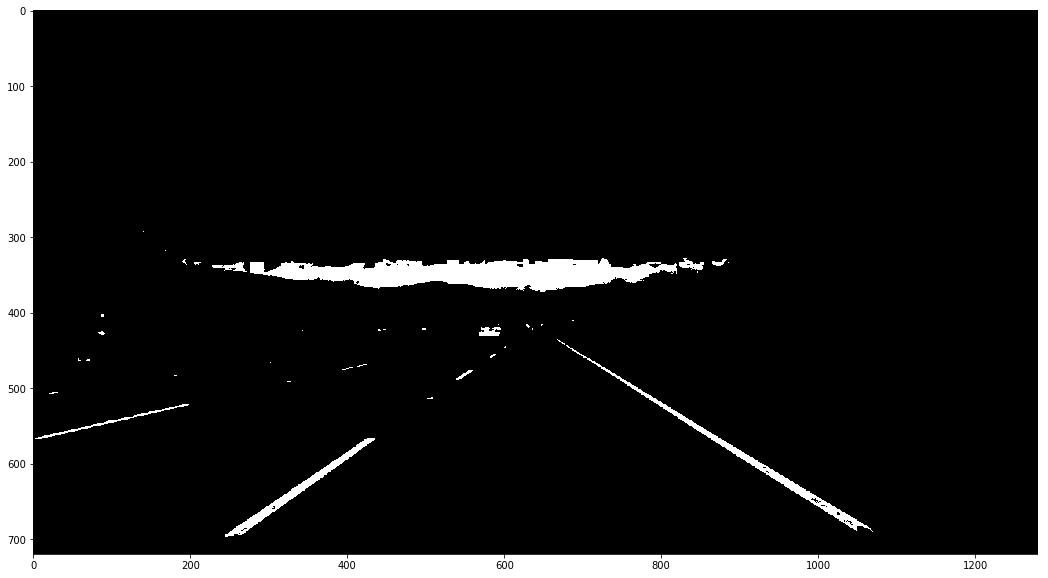

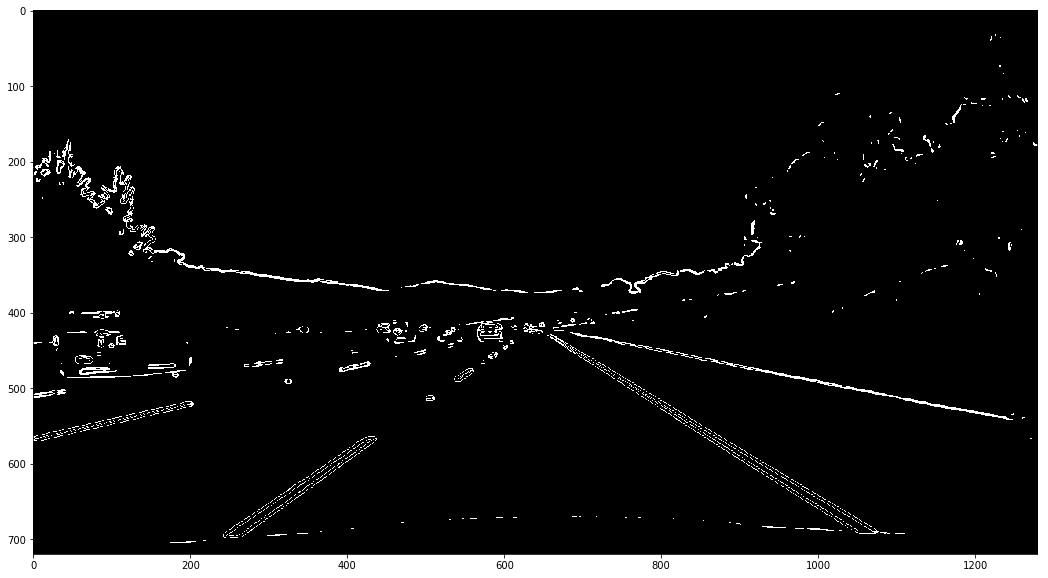

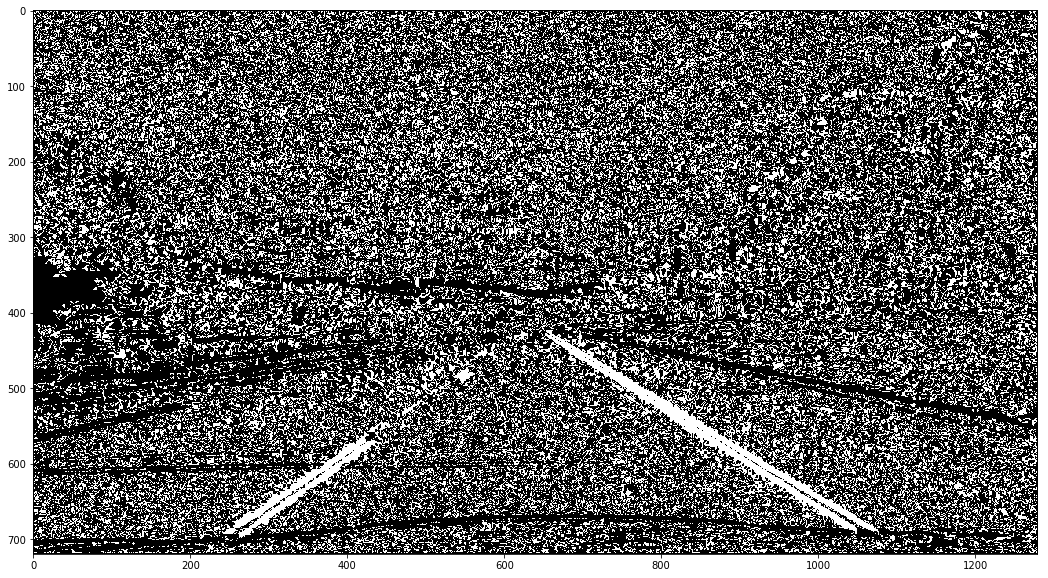

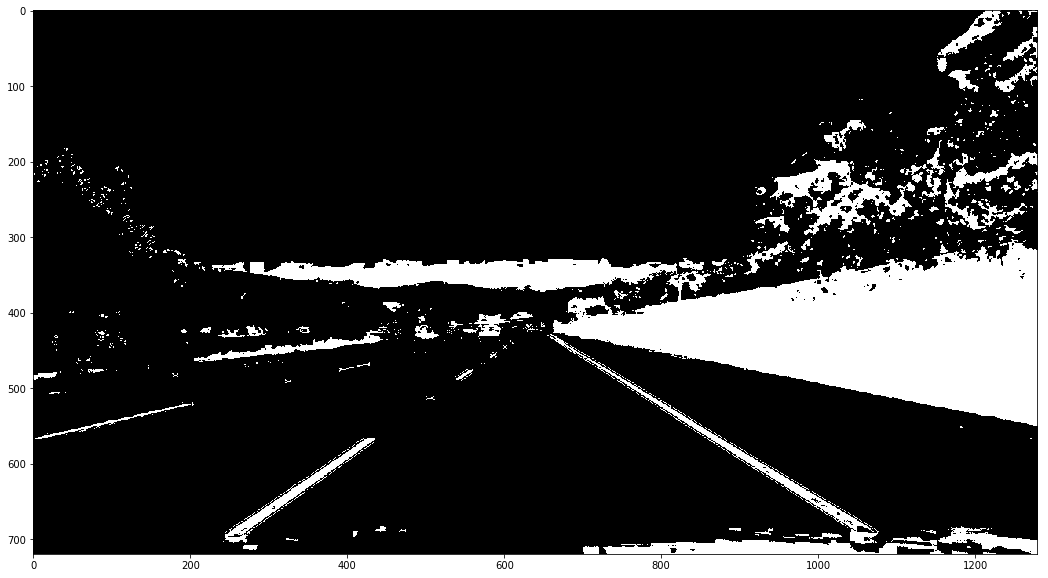

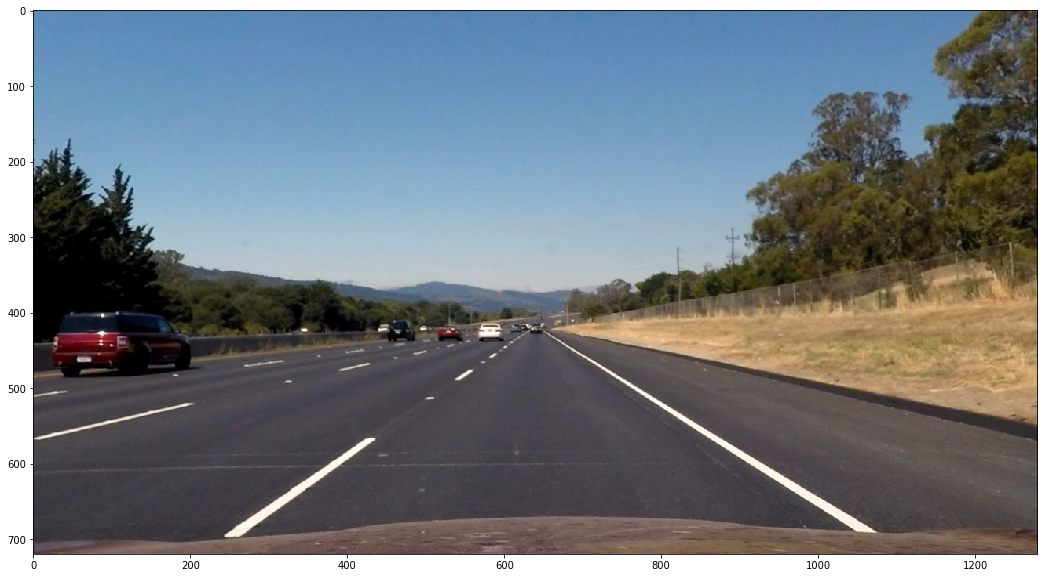

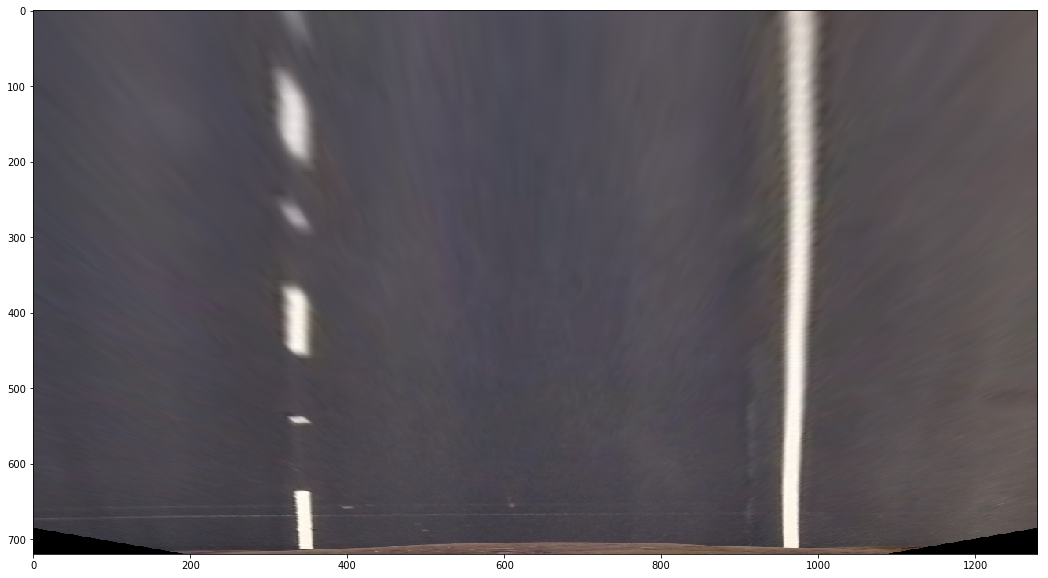

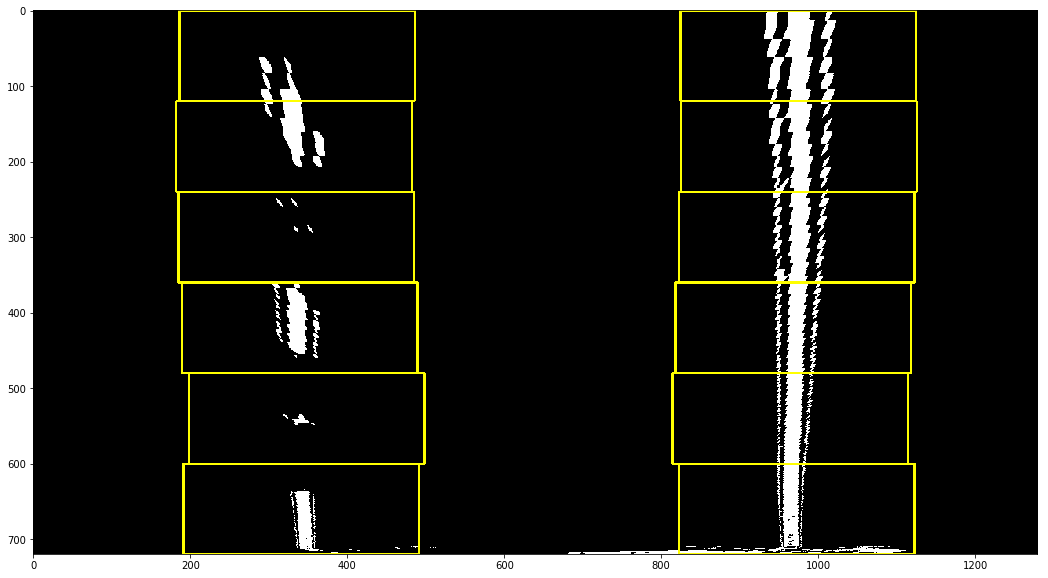

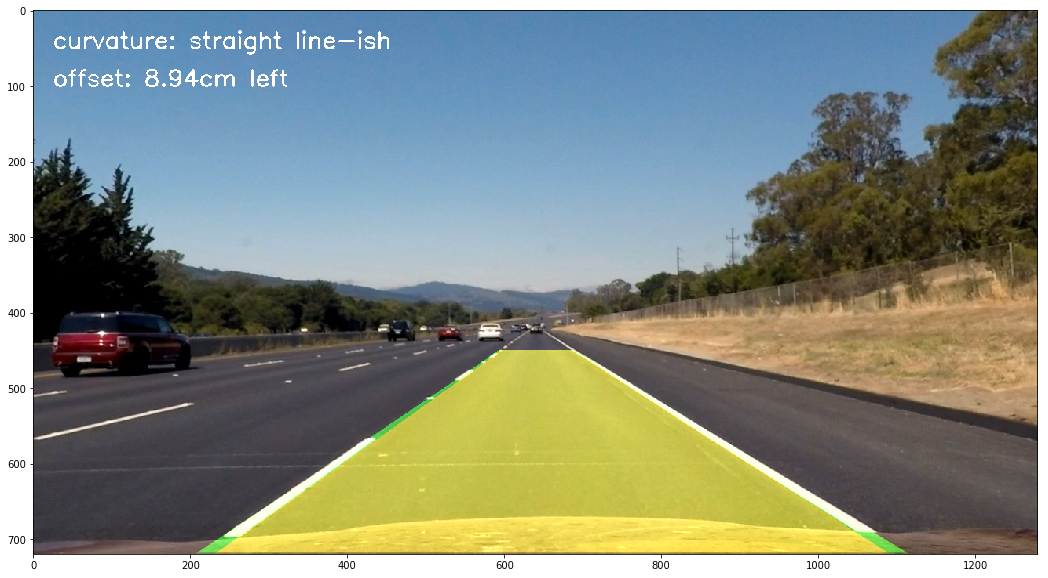

In [17]:
  
def debug_image(filename):
    reset_detections()
    process_image(mpimg.imread(filename), True)
    
    
def process_main_video():
    calibrate_for_main_video()
    process_video('project_video.mp4', 'project_video_with_lines.mp4')
#     process_video('project_video.mp4', 'project_video_with_lines_20_to_25.mp4', (20, 25))
#     process_video('project_video.mp4', 'project_video_with_lines_38_to_42.mp4', (38, 42))

def process_challenge_video():
    """
    Half-baked attempt at getting the challenge working
    """
    calibrate_for_challenge()
    process_video('challenge_video.mp4', 'challenge_video_with_lines.mp4')
        
# calibrate_for_main_video()
# debug_image('test_images/test1.jpg')
# debug_image('test_images/test2.jpg')
# debug_image('test_images/test3.jpg')
# debug_image('test_images/test4.jpg')
# debug_image('test_images/test5.jpg')
# debug_image('test_images/test6.jpg')
# debug_image('test_images/test7.jpg')
# debug_image('test_images/test8.jpg')
# debug_image('test_images/test9.jpg')
# debug_image('test_images/straight_lines1.jpg')
# debug_image('test_images/straight_lines2.jpg')
# debug_image('test_images/color-shadow-example.jpg')
# calibrate_for_challenge()
# debug_image('test_images/challenge_test1.jpg')
# debug_image('test_images/challenge_test2.jpg')
# debug_image('test_images/challenge_test3.jpg')


process_main_video()
# process_challenge_video()

